# RNN轨迹预测


改写自[算例](https://blog.csdn.net/weixin_45727931/article/details/114369073)。要求通过RNN，实现对如下三维运动轨迹的预测：

$$
\left \{
    \begin{aligned}
        x_{1} (t) &= 0.5 t, \\
        x_{2} (t) &= 0.6 \cos (t), \\
        x_{3} (t) &= 1.2 \sin (t).
    \end{aligned}
    \right.
$$


## 1.生成数据


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 时间历程
t = np.linspace(0, 20, 2001)


定义一个生成数据的函数


In [2]:
def GenerateData(Time):
    return np.concatenate((0.5 * Time + np.cos(Time) - 0.5 * np.sin(Time),
                           3 * np.cos(2 * Time), 2 * np.sin(4 * Time)),
                          axis=0).reshape(-1, 3)


生成数据


In [3]:
TimeHistory = GenerateData(t)
TimeHistory = np.concatenate((t.reshape(-1, 1), TimeHistory), axis=1)
print(TimeHistory.shape)


(2001, 4)


可视化轨迹


/tmp/ipykernel_1196885/98877340.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax1 = Axes3D(fig)
/home/ctc/anaconda3/envs/D2L/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/ctc/anaconda3/envs/D2L/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.pr

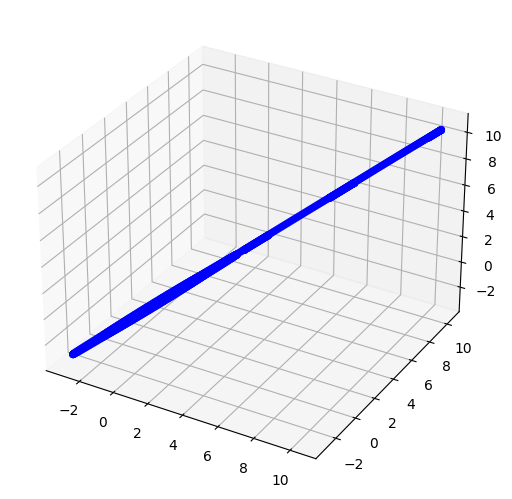

In [4]:
fig = plt.figure()
ax1 = Axes3D(fig)
ax1.scatter3D(TimeHistory[:, 1], TimeHistory[:, 2], TimeHistory[:, 3], c='b')
plt.show()


导出为Data.csv


In [5]:
import pandas as pd

Data4csv = pd.DataFrame(TimeHistory, columns=['Time', 'x1', 'x2', 'x3'])
Data4csv.to_csv('MyRNNExampleData.csv',index=False)


## 2.定义dataloader


通过类实现数据的读取


In [6]:
import torch
from torch.utils.data import DataLoader


class DataSetExample():

    def __init__(self, PATH):
        self.PATH = PATH

    def OpenFile(self):
        return pd.read_csv(self.PATH)

    def Value(self):
        return torch.tensor(self.OpenFile().values, dtype=torch.float32)


先把csv中的数据转为tensor


In [8]:
data = DataSetExample('MyRNNExampleData.csv').Value()[:, 1:]
data.shape


torch.Size([2001, 3])

## 3.定义RNN模型


首先定义好超参数
